# Capstone Project: Toronto

## Introduction

To solve the business problem in the week 1, we will use webscrapping to create a dataframe to then run an analysis to find all information realted to Indian restaurants in two boroughs, Brooklyn and Queens. Then, we will use the Foursquare API to futher explore neighborhoods, nearby venues, venue ratings, and tips. We will then use this feature to group the neighborhoods into clusters. You will use the _k_-means clustering algorithm to complete this task. At the end of this project, we will be able to give John a recommendation for the location of the new Indian restaurant in Toronto.

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [109]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')  # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Matplotlib version:  3.3.4
Libraries imported.


<a id='item1'></a>


## Download and Explore Dataset


In [110]:
res = requests.get('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json')

newyork_data=res.json()

In [111]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a _pandas_ dataframe


In [112]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Loading the data into the dataframe.


In [113]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.


In [114]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.


In [115]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Create a map of New York with neighborhoods superimposed on top.


In [116]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# 1. Exploring Queens 
#### While exploring Queens, we want to create a profile for a successful Indian restaurant. In order to make this successful, we will need to find if there are any frequently visited Indian restuarants in Queens, which neighborhoods they reside in, and what surrounding venues usually are associated with a successful Indian restaurant.

In [117]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)

In [118]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [119]:
# create map of Manhattan using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

## Define Foursquare Credentials and Version


In [120]:
CLIENT_ID = '3QCOYLJIYELE1O32XIQQFCQOA1PEHSTZCM0POEIJMUZUR10A' # your Foursquare ID
CLIENT_SECRET = 'P1AC0GGYPAPZF4JJOS03JHWJ4PMY43FQAVMQCL25BTM5ZPOT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3QCOYLJIYELE1O32XIQQFCQOA1PEHSTZCM0POEIJMUZUR10A
CLIENT_SECRET:P1AC0GGYPAPZF4JJOS03JHWJ4PMY43FQAVMQCL25BTM5ZPOT


## Exploring Our Test Neighborhood: Glendale


In [121]:
queens_data.loc[15, 'Neighborhood']

'Glendale'

In [122]:
neighborhood_latitude = queens_data.loc[15, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queens_data.loc[15, 'Longitude'] # neighborhood longitude value

neighborhood_name = queens_data.loc[15, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Glendale are 40.70276242967838, -73.87074167435605.


#### Now, let's get the top 100 venues that are in Glendale within a radius of 500 meters.


In [123]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url



'https://api.foursquare.com/v2/venues/explore?&client_id=3QCOYLJIYELE1O32XIQQFCQOA1PEHSTZCM0POEIJMUZUR10A&client_secret=P1AC0GGYPAPZF4JJOS03JHWJ4PMY43FQAVMQCL25BTM5ZPOT&v=20180605&ll=40.70276242967838,-73.87074167435605&radius=500&limit=100'

In [124]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61095ff675f7c634aad2fe17'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Glendale',
  'headerFullLocation': 'Glendale, Queens',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 40.70726243417838,
    'lng': -73.86481688168729},
   'sw': {'lat': 40.69826242517838, 'lng': -73.87666646702482}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf59791004ed13a56e540a0',
       'name': "Cook's Arts & Crafts Shoppe",
       'location': {'address': '80-09 Myrtle Ave',
        'crossStreet': '80th Street',
        'lat': 40.70316969249906,
        'lng': -73.86783671477868,
        'labeledLatLngs

In [125]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Cleaning the json and structure it into a _pandas_ dataframe.


In [126]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

<ipython-input-126-53c7dde730be>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Cook's Arts & Crafts Shoppe,Arts & Crafts Store,40.703170,-73.867837
1,Finback Brewery,Brewery,40.706567,-73.873179
2,Home Service Beer,Food & Drink Shop,40.703479,-73.871392
3,Bambino Pizza 2,Pizza Place,40.703112,-73.868178
4,Home Deli & Catering,Pizza Place,40.703479,-73.871390
5,Forest Park - Dry Harbor Playground,Park,40.702988,-73.867396
6,Roma Deli,Deli / Bodega,40.703411,-73.865311


In [127]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


<a id='item2'></a>


#### Let's create a function to repeat the same process to all the neighborhoods in Queens


In [128]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Creating a new dataframe called _queens_venues_.


In [129]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


#### Let's check the size of the resulting dataframe


In [130]:
print(queens_venues.shape)
queens_venues.head()

(2130, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant


### So, here is the breakdown off all the neighborhoods in the Queens borough and their venues.

In [131]:
Solution_1 = queens_venues['Venue Category'].value_counts()
Solution_1

Pizza Place                                 88
Deli / Bodega                               78
Chinese Restaurant                          62
Bakery                                      58
Donut Shop                                  50
Pharmacy                                    48
Bank                                        48
Bar                                         45
Korean Restaurant                           42
Italian Restaurant                          41
Supermarket                                 39
Coffee Shop                                 38
Sandwich Place                              38
Grocery Store                               37
Mexican Restaurant                          33
Gym / Fitness Center                        32
Beach                                       32
Bus Station                                 30
Latin American Restaurant                   30
Park                                        29
Café                                        28
Ice Cream Sho

### There are 17 Indian Restaurants in Queens. The next step is to find which neighborhoods have Indian restaurants.

In [132]:
Indian_Restaurants_Queens = queens_venues[queens_venues['Venue Category'].str.contains("Indian Restaurant")]
Indian_Restaurants_Queens

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,Astoria,40.768509,-73.915654,The Gully,40.766719,-73.912410,Indian Restaurant
20,Astoria,40.768509,-73.915654,Seva Indian Cuisine,40.765521,-73.919157,Indian Restaurant
30,Astoria,40.768509,-73.915654,Tikka Indian Grill,40.765397,-73.918658,Indian Restaurant
394,Kew Gardens,40.705179,-73.829819,Tikka Indian Grill,40.705874,-73.830942,Indian Restaurant
406,Kew Gardens,40.705179,-73.829819,Mehak Mughlai Cuisine,40.709164,-73.829509,Indian Restaurant
456,Richmond Hill,40.697947,-73.831833,Punjabi Kabab House,40.694523,-73.828254,Indian Restaurant
538,Long Island City,40.750217,-73.939202,Raj's Indian Kitchen,40.749976,-73.939261,Indian Restaurant
575,Long Island City,40.750217,-73.939202,The Halal Guys,40.753524,-73.938633,North Indian Restaurant
900,Bayside,40.766041,-73.774274,Ayna Agra Indian Restaurant,40.765478,-73.771737,Indian Restaurant
915,Bayside,40.766041,-73.774274,Masala Box,40.762674,-73.770682,Indian Restaurant


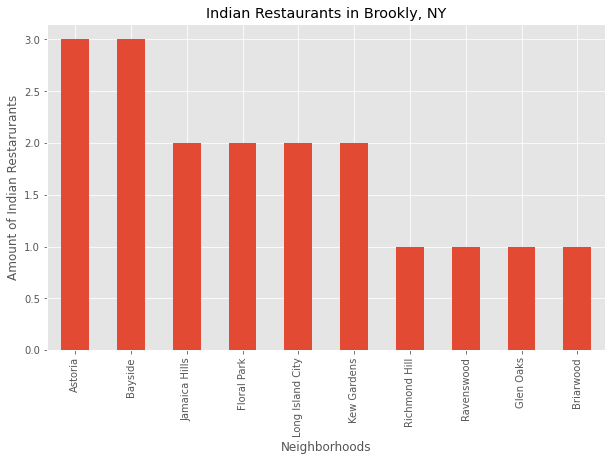

In [133]:
Solution_Q = Indian_Restaurants_Queens['Neighborhood'].value_counts()
Solution_Q.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Neighborhoods') # add to x-label to the plot
plt.ylabel('Amount of Indian Restarurants') # add y-label to the plot
plt.title('Indian Restaurants in Brookly, NY') # add title to the plot

plt.show()

Let's check how many venues were returned for each neighborhood


In [134]:
queens_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,21,21,21,21,21,21
Astoria,100,100,100,100,100,100
Astoria Heights,12,12,12,12,12,12
Auburndale,20,20,20,20,20,20
Bay Terrace,37,37,37,37,37,37
Bayside,74,74,74,74,74,74
Bayswater,2,2,2,2,2,2
Beechhurst,18,18,18,18,18,18
Bellaire,13,13,13,13,13,13


#### Let's find out how many unique categories can be curated from all the returned venues


In [135]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 272 uniques categories.


<a id='item3'></a>


## Analyze Neighborhoods Around Glendale


In [136]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Yoga Studio,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Wo

And let's examine the new dataframe size.


In [137]:
queens_onehot.shape

(2130, 272)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [138]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Wo

## Each neighborhoodsTop 5 Most Common Venues


In [139]:
num_top_venues = 5

for hood in queens_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = queens_grouped[queens_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
            venue  freq
0  Surf Spot       0.19
1  Sandwich Place  0.10
2  Metro Station   0.10
3  Wine Shop       0.05
4  BBQ Joint       0.05


----Astoria----
                       venue  freq
0  Bar                        0.06
1  Greek Restaurant           0.06
2  Hookah Bar                 0.05
3  Middle Eastern Restaurant  0.05
4  Seafood Restaurant         0.04


----Astoria Heights----
                venue  freq
0  Italian Restaurant  0.08
1  Pizza Place         0.08
2  Bus Station         0.08
3  Motel               0.08
4  Supermarket         0.08


----Auburndale----
                  venue  freq
0  Italian Restaurant    0.10
1  Pharmacy              0.05
2  Mattress Store        0.05
3  Fast Food Restaurant  0.05
4  Sushi Restaurant      0.05


----Bay Terrace----
                 venue  freq
0  Clothing Store       0.11
1  American Restaurant  0.08
2  Women's Store        0.05
3  Shoe Store           0.05
4  Cosmetics Shop       0.05


----Bayside----
   

#### Let's put that into a _pandas_ dataframe


In [140]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

## Creating a New Dataframe for the Neighborhoods Top 10 Venues


In [141]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Sandwich Place,Metro Station,Wine Shop,BBQ Joint,Coffee Shop,Beach,Tiki Bar,Café,Board Shop
1,Astoria,Bar,Greek Restaurant,Hookah Bar,Middle Eastern Restaurant,Seafood Restaurant,Indian Restaurant,Pizza Place,Bubble Tea Shop,Café,Bakery
2,Astoria Heights,Italian Restaurant,Pizza Place,Bus Station,Motel,Supermarket,Bowling Alley,Museum,Bakery,Hostel,Burger Joint
3,Auburndale,Italian Restaurant,Pharmacy,Mattress Store,Fast Food Restaurant,Sushi Restaurant,Supermarket,Miscellaneous Shop,Toy / Game Store,Hookah Bar,Bar
4,Bay Terrace,Clothing Store,American Restaurant,Women's Store,Shoe Store,Cosmetics Shop,Bank,Kids Store,Donut Shop,Mobile Phone Shop,Pharmacy


In [142]:
Indian_sorted = neighborhoods_venues_sorted[['Neighborhood','1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue',\
                                            '4th Most Common Venue','5th Most Common Venue']]

In [143]:
Indian_Search = Indian_sorted[Indian_sorted['1st Most Common Venue'].str.contains("Indian")]
Indian_Search

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,Floral Park,Indian Restaurant,Basketball Court,Salon / Barbershop,Grocery Store,Dosa Place


In [144]:
Indian_Search2 = Indian_sorted[Indian_sorted['2nd Most Common Venue'].str.contains("Indian")]
Indian_Search2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [145]:
Indian_Search3 = Indian_sorted[Indian_sorted['3rd Most Common Venue'].str.contains("Indian")]
Indian_Search3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Briarwood,Deli / Bodega,Playground,Indian Restaurant,Gym,Arts & Crafts Store
15,Brookville,Deli / Bodega,Yoga Studio,North Indian Restaurant,Outdoors & Recreation,Other Nightlife
40,Jamaica Hills,Fast Food Restaurant,Donut Shop,Indian Restaurant,Pharmacy,Thai Restaurant


In [146]:
Indian_Search4 = Indian_sorted[Indian_sorted['4th Most Common Venue'].str.contains("Indian")]
Indian_Search4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Bayside,Bar,Sushi Restaurant,Pub,Indian Restaurant,Pizza Place
6,Bayswater,Construction & Landscaping,Playground,Yoga Studio,North Indian Restaurant,Outdoors & Recreation
48,Malba,Tennis Court,Rest Area,Yoga Studio,North Indian Restaurant,Other Nightlife


In [147]:
Indian_Search5 = Indian_sorted[Indian_sorted['5th Most Common Venue'].str.contains("Indian")]
Indian_Search5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


# 1. Our Analysis on Queens Regarding Indian Restaurants

#### As we breakdown the neighborhoods where Indian Resturants are part of the top five common venues. We see that Indian restaurants that are most frequently visited (1st and 2nd) are alone in their neighborhoods and don't really have a profile. Frequently visited (3rd and 4th) represent more neighborhoods which gives us similiar associated venues that surround each restaurant, while 5th is really by itself. So, looking at the venues surrounding these venues, we can see that some reoccurring venues are: Pizza Place, Yoga, Chinese Restaurants, and other ethnic restaurants.

# 2. Brooklyn Indian Resturant Analysis
#### Now, lets take the previous methodology that we used for Queens and apply it to Brooklyn. We want to see if Indian Resturants in this area also share common frequently visited venues to see if we can develop a profile for our consumer and a profile for a neighborhood. 

In [148]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [149]:
# create map of Manhattan using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

In [150]:
brooklyn_data.loc[42, 'Neighborhood']
neighborhood_latitude = brooklyn_data.loc[42, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[42, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[42, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Prospect Lefferts Gardens are 40.658420017469815, -73.95489867077713.


### Defining Foursquare Using the Access Token

In [151]:
CLIENT_ID = '3QCOYLJIYELE1O32XIQQFCQOA1PEHSTZCM0POEIJMUZUR10A' # your Foursquare ID
CLIENT_SECRET = 'P1AC0GGYPAPZF4JJOS03JHWJ4PMY43FQAVMQCL25BTM5ZPOT' # your Foursquare Secret
ACCESS_TOKEN = 'XEQFBJVGZMD121HSWOPX3VS5FIMIGG2GEIKLXNHFH0JAKECN'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3QCOYLJIYELE1O32XIQQFCQOA1PEHSTZCM0POEIJMUZUR10A
CLIENT_SECRET:P1AC0GGYPAPZF4JJOS03JHWJ4PMY43FQAVMQCL25BTM5ZPOT


In [152]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61096021d18fec39507a4ca5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Prospect Lefferts Gardens',
  'headerFullLocation': 'Prospect Lefferts Gardens, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 49,
  'suggestedBounds': {'ne': {'lat': 40.66292002196982,
    'lng': -73.94897781809557},
   'sw': {'lat': 40.65392001296981, 'lng': -73.96081952345868}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5389f295498e264f18c5d652',
       'name': 'PLG Coffee House and Tavern',
       'location': {'address': '499 Rogers Ave',
        'crossStreet': 'Midwood St',
        'lat': 40.

In [153]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-153-13e91fe4f6ae>:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,PLG Coffee House and Tavern,Café,40.660007,-73.953362
1,Hamlet Coffee Company,Coffee Shop,40.660840,-73.953520
2,The Owl Music Parlor,Music Venue,40.660109,-73.953193
3,DaleView Biscuits & Beer,Café,40.658921,-73.950757
4,Gandhi Fine Indian Cuisine,Indian Restaurant,40.655168,-73.956325


## Exploring the Neighborhood in Brooklyn

In [154]:
#Creating a function to process all Brooklyn Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#Creating a new dataframe called brooklyn_venues
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )


Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


## Now we are returing all the Brooklyn venues and the venue category

In [155]:
Solution_1a = brooklyn_venues['Venue Category'].value_counts()
Solution_1a

Pizza Place                                 125
Coffee Shop                                 99 
Bar                                         79 
Deli / Bodega                               69 
Italian Restaurant                          67 
Bakery                                      62 
Grocery Store                               60 
Chinese Restaurant                          55 
Café                                        48 
Ice Cream Shop                              46 
Pharmacy                                    45 
Park                                        45 
Sandwich Place                              44 
Bagel Shop                                  44 
Mexican Restaurant                          43 
American Restaurant                         41 
Bank                                        39 
Cocktail Bar                                39 
Caribbean Restaurant                        38 
Donut Shop                                  37 
Wine Shop                               

## Foursquare has returned 17 Indian restaurants, now let's locate where these restaurants are

In [156]:
Indian_Restaurants_Brooklyn = brooklyn_venues[brooklyn_venues['Venue Category'].str.contains("Indian Restaurant")]
Indian_Restaurants_Brooklyn

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
47,Bay Ridge,40.625801,-74.030621,Bombay Grill,40.622371,-74.031799,Indian Restaurant
247,Greenpoint,40.730201,-73.954241,Agra Taj Mahal,40.733321,-73.954928,Indian Restaurant
679,Bushwick,40.698116,-73.925258,Agra Heights,40.698094,-73.921355,Indian Restaurant
784,Brooklyn Heights,40.695864,-73.993782,Curry Heights,40.693572,-73.992265,Indian Restaurant
813,Brooklyn Heights,40.695864,-73.993782,Asya Indian Restaurant,40.699607,-73.992110,Indian Restaurant
889,Cobble Hill,40.687920,-73.998561,Indian Table,40.685965,-73.994195,Indian Restaurant
1087,Gowanus,40.673931,-73.994441,Kanan's Indian Restaurant,40.671891,-73.990940,Indian Restaurant
1160,Fort Greene,40.688527,-73.972906,Dosa Royale,40.689466,-73.968704,Indian Restaurant
1499,Clinton Hill,40.693229,-73.967843,Dosa Royale,40.689466,-73.968704,Indian Restaurant
1501,Clinton Hill,40.693229,-73.967843,Spice & Grill,40.693389,-73.968028,Indian Restaurant


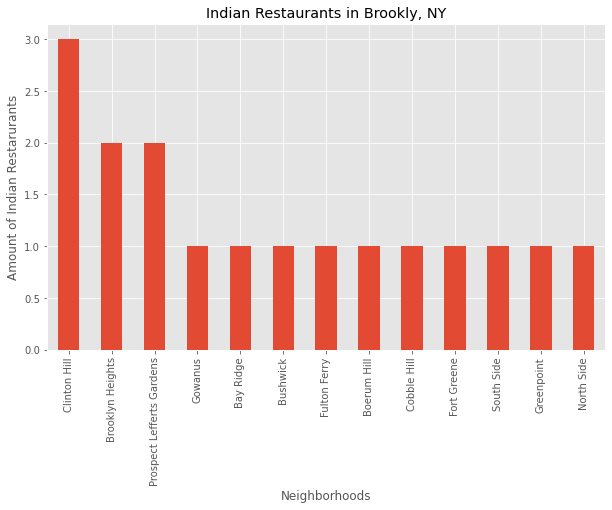

In [157]:
Solution_B = Indian_Restaurants_Brooklyn['Neighborhood'].value_counts()
Solution_B.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Neighborhoods') # add to x-label to the plot
plt.ylabel('Amount of Indian Restarurants') # add y-label to the plot
plt.title('Indian Restaurants in Brookly, NY') # add title to the plot

plt.show()

In [158]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped.shape

(70, 285)

In [159]:
# Get the top most common venues
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                venue  freq
0  Chinese Restaurant  0.06
1  Dessert Shop        0.04
2  Asian Restaurant    0.04
3  Bubble Tea Shop     0.04
4  Sushi Restaurant    0.04


----Bay Ridge----
                 venue  freq
0  Spa                  0.06
1  Pizza Place          0.06
2  Bagel Shop           0.05
3  Italian Restaurant   0.05
4  American Restaurant  0.04


----Bedford Stuyvesant----
            venue  freq
0  Bar             0.10
1  Coffee Shop     0.10
2  Café            0.06
3  Playground      0.06
4  Discount Store  0.03


----Bensonhurst----
                venue  freq
0  Donut Shop          0.06
1  Park                0.06
2  Italian Restaurant  0.06
3  Chinese Restaurant  0.06
4  Ice Cream Shop      0.06


----Bergen Beach----
               venue  freq
0  Harbor / Marina    0.25
1  Other Repair Shop  0.12
2  Moving Target      0.12
3  Baseball Field     0.12
4  Playground         0.12


----Boerum Hill----
                 venue  freq
0  Coffee Shop      

In [160]:
#Create a dataframe for the results
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Dessert Shop,Asian Restaurant,Bubble Tea Shop,Sushi Restaurant,Pharmacy,Donut Shop,Italian Restaurant,Gas Station,Pizza Place
1,Bay Ridge,Spa,Pizza Place,Bagel Shop,Italian Restaurant,American Restaurant,Greek Restaurant,Bar,Chinese Restaurant,Hookah Bar,Playground
2,Bedford Stuyvesant,Bar,Coffee Shop,Café,Playground,Discount Store,Thrift / Vintage Store,Bus Station,Cocktail Bar,Community Center,Deli / Bodega
3,Bensonhurst,Donut Shop,Park,Italian Restaurant,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Pet Store,Shabu-Shabu Restaurant,Cosmetics Shop,Coffee Shop
4,Bergen Beach,Harbor / Marina,Other Repair Shop,Moving Target,Baseball Field,Playground,Park,Athletics & Sports,Paper / Office Supplies Store,Pakistani Restaurant,Outlet Store


## Looking at the data, there isn't a top ten most common venue in Brooklyn, so we are going to use Foursquare to find a successful restaurant and find the surrounding resturants and any tips we can use.

In [161]:
search_query = 'Indian Restaurant'
radius = 1000
LIMIT = 100
urlbk = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

resultsbk = requests.get(urlbk).json()

# assign relevant part of JSON to venues
venuesbk = resultsbk['response']['venues']

# tranform venues into a dataframe
dataframebk = json_normalize(venuesbk)
dataframebk.head()

<ipython-input-161-0525c80c8627>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframebk = json_normalize(venuesbk)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id,location.neighborhood
0,4f32549519836c91c7cd23e2,C B Finger Licking Jamaican and West Indian Restaurant,"[{'id': '4d4b7105d754a06374d81259', 'name': 'Food', 'pluralName': 'Food', 'shortName': 'Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}]",v-1628004418,False,1617 Nostrand Ave,40.646622,-73.948807,"[{'label': 'entrance', 'lat': 40.646603, 'lng': -73.94898}, {'label': 'display', 'lat': 40.64662170410156, 'lng': -73.94880676269531}]",1410,11226,US,Brooklyn,NY,United States,"[1617 Nostrand Ave, Brooklyn, NY 11226]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}]",v-1628004418,False,2032 Bedford Ave,40.655168,-73.956325,"[{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}]",381,11226,US,Brooklyn,NY,United States,"[2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave), Brooklyn, NY 11226]",btwn Clarkson Ave & Parkside Ave,275754,https://www.seamless.com/menu/gandhi-2032-bedford-ave-brooklyn/275754?affiliate=1131&utm_source=foursquare-affiliate-network&utm_medium=affiliate&utm_campaign=1131&utm_content=275754,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,105464962,NaN
2,4f1b3405e4b0889e05125d4d,3-D's West Indian & American Bakery & Restaurant,"[{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}]",v-1628004418,False,403 Empire Blvd,40.664244,-73.948888,"[{'label': 'display', 'lat': 40.664244, 'lng': -73.948888}, {'label': 'entrance', 'lat': 40.664175, 'lng': -73.948807}]",823,11225,US,Brooklyn,NY,United States,"[403 Empire Blvd, Brooklyn, NY 11225]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5185d419498e8f5d00b5ddab,2S Mart West Indian & American Grocery,"[{'id': '4bf58dd8d48988d1fa941735', 'name': 'Farmers Market', 'pluralName': 'Farmers Markets', 'shortName': 'Farmer's Market', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_farmersmarket_', 'suffix': '.png'}, 'primary': True}]",v-1628004418,False,781 Flatbush Ave,40.653724,-73.959152,"[{'label': 'display', 'lat': 40.653724, 'lng': -73.959152}, {'label': 'entrance', 'lat': 40.653697, 'lng': -73.959332}]",634,11226,US,Brooklyn,NY,United States,"[781 Flatbush Ave (Lenox Ave), Brooklyn, NY 11226]",Lenox Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4e8616decc210aef90977b77,JJ's Jamaican Restaurant,"[{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}]",v-1628004418,False,711 Flatbush Ave,40.655792,-73.959966,"[{'label': 'display', 'lat': 40.65579200119492, 'lng': -73.95996582691308}, {'label': 'entrance', 'lat': 40.655832, 'lng': -73.959748}]",518,11225,US,Brooklyn,NY,United States,"[711 Flatbush Ave (Parkside Ave), Brooklyn, NY 11225]",Parkside Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columnsbk = ['name', 'categories'] + [col for col in dataframebk.columns if col.startswith('location.')] + ['id']
dataframe_filteredbk = dataframebk.loc[:, filtered_columnsbk]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filteredbk['categories'] = dataframe_filteredbk.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filteredbk.columns = [column.split('.')[-1] for column in dataframe_filteredbk.columns]

In [163]:
venues_mapbk = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Brooklyn Venues',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_mapbk)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filteredbk.lat, dataframe_filteredbk.lng, dataframe_filteredbk.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapbk)

# display map
venues_mapbk

## We found out that Gandhi Fine Indian Cuisine has a good rating of 8.8/10. We will use this restaurant to see if the nearby venues are common to the venues found in Queens and gain any tips that we could use to find a location.

In [164]:
venue_id = '4bb93b70cf2fc9b6fe64a002' # ID of Gandhi Fine Indian Cuisine
Gandhi_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)

Gandhi_result = requests.get(Gandhi_url).json()
print(Gandhi_result['response']['venue'].keys())
Gandhi_result['response']['venue']

try:
    print(Gandhi_result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'like', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'delivery', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])
8.8


In [165]:
Gandhi_result['response']['venue']['tips']['count']

48

In [166]:
limit = 50 # set limit to be greater than or equal to the total number of tips
GT_url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&oauth_token={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION, limit)

GT_results = requests.get(GT_url).json()

tips = GT_results['response']['tips']['items']

tip = GT_results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'likes', 'like', 'logView', 'agreeCount', 'disagreeCount', 'todo', 'user'])

In [167]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered.reindex()

<ipython-input-167-252e55242536>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
<ipython-input-167-252e55242536>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  tips_df = json_normalize(tips) # json normalize tips


,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.id
0,Delicious food and really nice people. Love ordering from here :),3,0,5b01e8810313207595cec1c1,Cindy,Tsui,488602704
1,"You can't miss -- everything is yummy. My favorite Indian restaurant in Brooklyn (and I'm a Brit who grew up on the cuisine), one of the best anywhere in NYC. Short on atmosphere, but lovely owners.",2,0,4d71928e95bc8eecbf175cf9,Stephen,Francis,7383701


## We did not find any tips to help us here in Brooklyn. There are many Indian Resturants in Brooklyn. However, the lack of being a top ten common venue in each neighborhood, we cannot tell if there is correlation with the surrounding venues. So, with our last effort, look that the tips and reviews to see why the customers love it. The two customers left nice remarks but did not give us too much besides great customer service and good food. So, we decided to take the location of Gandhi Fine Indian Cusine and look at the resturants around it to see if it has any correlation with what we see in Queens.

In [168]:
#Looking further into the Location
GT_latitude = 40.655168
GT_longitude = -73.956325
GTurl = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, GT_latitude, GT_longitude, VERSION, radius, LIMIT)
GTurl
import requests
GTresults = requests.get(GTurl).json()
'There are {} around Gandi Fine Indian Cuisine.'.format(len(GTresults['response']['groups'][0]['items']))
items = GTresults['response']['groups'][0]['items']
items[0]
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head()

<ipython-input-168-edd426856813>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(items) # flatten JSON


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Gandhi Fine Indian Cuisine,Indian Restaurant,2032 Bedford Ave,btwn Clarkson Ave & Parkside Ave,40.655168,-73.956325,"[{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}]",0,11226,US,Brooklyn,NY,United States,"[2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave), Brooklyn, NY 11226, United States]",NaN,4bb93b70cf2fc9b6fe64a002
1,Peppa's Jerk Chicken,Caribbean Restaurant,738 Flatbush Ave,NaN,40.654953,-73.959783,"[{'label': 'display', 'lat': 40.6549534950897, 'lng': -73.9597826766333}]",292,11226,US,New York,NY,United States,"[738 Flatbush Ave, New York, NY 11226, United States]",NaN,4a6cba95f964a52073d11fe3
2,Risbo,Restaurant,701 Flatbush Ave,Parkside Ave. & Winthrop St.,40.656012,-73.959912,"[{'label': 'display', 'lat': 40.65601193402393, 'lng': -73.9599115311251}]",317,11225,US,New York,NY,United States,"[701 Flatbush Ave (Parkside Ave. & Winthrop St.), New York, NY 11225, United States]",NaN,59cfb148e2d4aa3bd74f6d80
3,The Rogers Garden,Cocktail Bar,708 Rogers Ave,NaN,40.654120,-73.953150,"[{'label': 'display', 'lat': 40.65412, 'lng': -73.95315}]",292,11226,US,Brooklyn,NY,United States,"[708 Rogers Ave, Brooklyn, NY 11226, United States]",NaN,5f10d90259d1cc1a72893b39
4,MangoSeed Restaurant,Caribbean Restaurant,757 Flatbush Ave,btwn Lenox Rd & Clarkson Ave,40.654414,-73.959494,"[{'label': 'entrance', 'lat': 40.65448, 'lng': -73.959476}, {'label': 'display', 'lat': 40.6544137621462, 'lng': -73.95949423313141}]",280,11226,US,Brooklyn,NY,United States,"[757 Flatbush Ave (btwn Lenox Rd & Clarkson Ave), Brooklyn, NY 11226, United States]",NaN,4bdcade72a3a0f470fecb3b6


## Now let's look at the venues that surrounding Gandhi Fine Indian Cuisine

In [169]:
dataframe_filtered.sort_values(by='distance')

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Gandhi Fine Indian Cuisine,Indian Restaurant,2032 Bedford Ave,btwn Clarkson Ave & Parkside Ave,40.655168,-73.956325,"[{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}]",0,11226,US,Brooklyn,NY,United States,"[2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave), Brooklyn, NY 11226, United States]",NaN,4bb93b70cf2fc9b6fe64a002
87,Mike's Pizza,Pizza Place,2026 Bedford Ave,btw Parkside Ave. & Clarkson Ave.,40.655308,-73.956439,"[{'label': 'display', 'lat': 40.65530786402606, 'lng': -73.95643906169329}, {'label': 'entrance', 'lat': 40.655306, 'lng': -73.956478}]",18,11226,US,Brooklyn,NY,United States,"[2026 Bedford Ave (btw Parkside Ave. & Clarkson Ave.), Brooklyn, NY 11226, United States]",NaN,4c7175d93bbbbfb73d551660
5,ZuriLee Pizza Bar,Pizza Place,755 Flatbush Ave,Clarkson Avenue & Lenox Road,40.654513,-73.959320,"[{'label': 'display', 'lat': 40.6545125, 'lng': -73.95932049999999}, {'label': 'entrance', 'lat': 40.654503, 'lng': -73.959478}]",263,11226,US,Brooklyn,NY,United States,"[755 Flatbush Ave (Clarkson Avenue & Lenox Road), Brooklyn, NY 11226, United States]",NaN,564fc417498e58f2bfed7138
4,MangoSeed Restaurant,Caribbean Restaurant,757 Flatbush Ave,btwn Lenox Rd & Clarkson Ave,40.654414,-73.959494,"[{'label': 'entrance', 'lat': 40.65448, 'lng': -73.959476}, {'label': 'display', 'lat': 40.6544137621462, 'lng': -73.95949423313141}]",280,11226,US,Brooklyn,NY,United States,"[757 Flatbush Ave (btwn Lenox Rd & Clarkson Ave), Brooklyn, NY 11226, United States]",NaN,4bdcade72a3a0f470fecb3b6
40,House of Juice,Juice Bar,642 Rodgers Ave,Parkside Ave,40.655883,-73.953059,"[{'label': 'display', 'lat': 40.65588329066326, 'lng': -73.95305880347966}]",287,11226,US,Brooklyn,NY,United States,"[642 Rodgers Ave (Parkside Ave), Brooklyn, NY 11226, United States]",NaN,55e1cbfc498e18a2dbab4126
13,Jamaican Pride Bakery,Bakery,731 Flatbush Ave,Clarkson Ave,40.655181,-73.959776,"[{'label': 'display', 'lat': 40.65518130144999, 'lng': -73.959776004109}, {'label': 'entrance', 'lat': 40.655179, 'lng': -73.959608}]",291,11226,US,Brooklyn,NY,United States,"[731 Flatbush Ave (Clarkson Ave), Brooklyn, NY 11226, United States]",NaN,4d92809cb189721e67fc232a
1,Peppa's Jerk Chicken,Caribbean Restaurant,738 Flatbush Ave,NaN,40.654953,-73.959783,"[{'label': 'display', 'lat': 40.6549534950897, 'lng': -73.9597826766333}]",292,11226,US,New York,NY,United States,"[738 Flatbush Ave, New York, NY 11226, United States]",NaN,4a6cba95f964a52073d11fe3
3,The Rogers Garden,Cocktail Bar,708 Rogers Ave,NaN,40.654120,-73.953150,"[{'label': 'display', 'lat': 40.65412, 'lng': -73.95315}]",292,11226,US,Brooklyn,NY,United States,"[708 Rogers Ave, Brooklyn, NY 11226, United States]",NaN,5f10d90259d1cc1a72893b39
12,Flatbush Zombie House,Tiki Bar,734 Flatbush Ave,Flatbush & Parkside,40.655045,-73.959842,"[{'label': 'display', 'lat': 40.65504475274442, 'lng': -73.95984203277688}, {'label': 'entrance', 'lat': 40.655068, 'lng': -73.959885}]",297,11226,US,Brooklyn,NY,United States,"[734 Flatbush Ave (Flatbush & Parkside), Brooklyn, NY 11226, United States]",Prospect Lefferts Gardens,59bc960a603d2a17e3d17e8c
6,Zen Vegetarian House,Vegetarian / Vegan Restaurant,773 Flatbush Ave,Clarkson Ave,40.653919,-73.959496,"[{'label': 'display', 'lat': 40.65391862147629, 'lng': -73.95949624327238}, {'label': 'entrance', 'lat': 40.653952, 'lng': -73.959377}]",301,11226,US,Brooklyn,NY,United States,"[773 Flatbush Ave (Clarkson Ave), Brooklyn, NY 11226, United States]",NaN,4a89d100f964a520160920e3


In [170]:
venues_map = folium.Map(location=[GT_latitude, GT_longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.CircleMarker(
    [GT_latitude, GT_longitude],
    radius=10,
    popup='Gandhi Fine Indian Cuisine',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

# 2. Our Analysis on Brooklyn Regarding Indian Restaurants

#### When starting this exploration of Brooklyn, we were hoping that the methodology would allow us to match Queens results with Brooklyn. However, as there weren't any frequently visited Indian Restaurants (at least top 10), we decided to look for an Indian restaruant that had a high rating. We had settled on Gandhi Fine Cuisine which has an 8.8/10 approval rating. This is a successful resturant so we wanted to see the surrounding venues to see if we can still use the profile found in Queens. When looking around the Gandhi Fine Indian Cuisine, we see that the surrounding venues are pizza restaurants, Yoga/Yoga Studios, Chinese restaurants, and other Ethnic Restaurants. So, even though this restaurant isn't frequently visited, it is still successful and all the profile for the surrounding neighborhoods and venues match the profiles from Queens. Now that we have a profile, we can test this profile in Toronto.

# 3. Applying Our Analysis in Toronto
#### We believe that we have enough data to show where John should advise Mike on where to develop this new Indian restaurant in Toronto. The profile of successful Indian restaurants is created by the surrounding neighborhood and venues. If we can find a profile in Toronto that is parrallel to New York, then we can properly advise John.

## Toronto: Downloading and Webscrapping 

In [171]:
!pip install bs4
from bs4 import BeautifulSoup
import requests
import pandas as pd
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
print('import complete')

import complete


In [172]:
#Prepping the Data for Webscrapping 
data = requests.get(url).text
soup = BeautifulSoup(data, "html5lib")
table = soup.find('table')

#Webscrapping 
table_contents =[]
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace('/',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
# Creating the Pandas Dataframe (df)
df=pd.DataFrame(table_contents)

df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                     'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [173]:
geodf=pd.read_csv(r'C:\Users\User\Desktop\Coursera\IBM Data Science Certificate\Course 10 Applied Data Science Capstone\Geospatial_Coordinates.csv')

#Renaming the Postal Code Column to be able to merge
geodf.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
Torontodf = pd.merge(df, geodf, on='PostalCode', how='inner')
Torontodf.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Exploring the Neighborhoods in Toronto

In [174]:
import json
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Torontodf['Borough'].unique()),
        Torontodf.shape[0]
    )
)
#Finding the Toronto Latitude and Longitude 
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

The dataframe has 15 boroughs and 103 neighborhoods.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Map Toronto's Neighborhoods

In [175]:
#Creating a map of Toronto, ON using Lat, Long
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, borough, neighborhood in zip(Torontodf['Latitude'], Torontodf['Longitude'], Torontodf['Borough'], Torontodf['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [176]:
Torontodf.loc[4, 'Neighborhood']
neighborhood_latitude = Torontodf.loc[4, 'Latitude']
neighborhood_longitude = Torontodf.loc[4, 'Longitude']

neighborhood_name = Torontodf.loc[4, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ontario Provincial Government are 43.6623015, -79.3894938.


## Top 50 Venues Around Ontario Provincial Government

In [177]:
LIMIT = 50
radius = 500

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-177-765f16bf8ba3>:30: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Queen's Park,Park,43.663946,-79.392180
1,Mercatto,Italian Restaurant,43.660391,-79.387664
2,Nando's,Portuguese Restaurant,43.661728,-79.386391
3,NEO COFFEE BAR,Coffee Shop,43.660130,-79.385830
4,Bar Volo,Beer Bar,43.665462,-79.385692


In [178]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Toronto_venues = getNearbyVenues(names=Torontodf['Neighborhood'],
                                   latitudes=Torontodf['Latitude'],
                                   longitudes=Torontodf['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park , Harbourfront
Lawrence Manor , Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern , Rouge
Don Mills North
Parkview Hill , Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Rouge Hill , Port Union , Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Guildwood , Morningside , West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Thorncliffe Park
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Scarborough Village
Fairview , Henry Farm , Oriole
Northwood Park , York University
The Danforth  East
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
Kennedy Park , Ionview , East Birchmount Park
Bayview Village

## Displaying All Indian Restaurants in Toronto

In [179]:
Indian_Restaurants_Toronto = Toronto_venues[Toronto_venues['Venue Category'].str.contains("Indian Restaurant")]
Indian_Restaurants_Toronto

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
398,Central Bay Street,43.657952,-79.387383,Colaba Junction,43.660940,-79.385635,Indian Restaurant
463,Thorncliffe Park,43.705369,-79.349372,Iqbal Kebab & Sweet Centre,43.705923,-79.351521,Indian Restaurant
471,Thorncliffe Park,43.705369,-79.349372,Hakka Garden,43.704578,-79.349770,Indian Restaurant
743,"The Danforth West , Riverdale",43.679557,-79.352188,Sher-E-Punjab,43.677308,-79.353066,Indian Restaurant
969,"Bedford Park , Lawrence Manor East",43.733283,-79.419750,The Copper Chimney,43.736195,-79.420271,Indian Restaurant
1051,"Dorset Park , Wexford Heights , Scarborough Town Centre",43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
1054,"Dorset Park , Wexford Heights , Scarborough Town Centre",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
1137,"The Annex , North Midtown , Yorkville",43.672710,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
1195,Davisville,43.704324,-79.388790,Marigold Indian Bistro,43.702881,-79.388008,Indian Restaurant
1496,"St. James Town , Cabbagetown",43.667967,-79.367675,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant


In [180]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood , Long Branch",8,8,8,8,8,8
"Bathurst Manor , Wilson Heights , Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",27,27,27,27,27,27
Berczy Park,50,50,50,50,50,50
"Birch Cliff , Cliffside West",5,5,5,5,5,5
"Brockton , Parkdale Village , Exhibition Place",22,22,22,22,22,22
"CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport",15,15,15,15,15,15


In [181]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

Toronto_grouped.shape

(99, 254)

## Top 5 Common Venues (As the above grouping did not show us much frequency)

In [182]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Lounge                     0.2 
1  Breakfast Spot             0.2 
2  Latin American Restaurant  0.2 
3  Skating Rink               0.2 
4  Clothing Store             0.2 


----Alderwood , Long Branch----
            venue  freq
0  Pizza Place     0.25
1  Sandwich Place  0.12
2  Dance Studio    0.12
3  Gym             0.12
4  Pharmacy        0.12


----Bathurst Manor , Wilson Heights , Downsview North----
              venue  freq
0  Coffee Shop       0.10
1  Bank              0.10
2  Shopping Mall     0.05
3  Sushi Restaurant  0.05
4  Supermarket       0.05


----Bayview Village----
                 venue  freq
0  Café                 0.25
1  Japanese Restaurant  0.25
2  Bank                 0.25
3  Chinese Restaurant   0.25
4  Movie Theater        0.00


----Bedford Park , Lawrence Manor East----
                venue  freq
0  Pizza Place         0.07
1  Coffee Shop         0.07
2  Sandwich Place      0.07
3  Italian Restaurant

In [183]:
# Put into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

Indian_Search = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains("Indian")]
Indian_Search

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Dorset Park , Wexford Heights , Scarborough Town Centre",Indian Restaurant,Pet Store,Brewery,Chinese Restaurant,Vietnamese Restaurant,Monument / Landmark,Music Venue,Museum,Movie Theater,Motel
86,Thorncliffe Park,Indian Restaurant,Yoga Studio,Intersection,Burger Joint,Bus Line,Supermarket,Sandwich Place,Liquor Store,Bank,Gas Station


### When Indian Restaurant is the most common venue (1st), some other common venues are common to venues found in Queens and Brooklyn (Chinese Restaurant, Yoga, Fast Food, and other Ethnic Restaurants) meaning that we can profile our customer to these surrounding venues. Now let's find a neighborhood to scout by using K-Means.

## Clusting Neighborhoods Using K-Means

In [185]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
Toronto_merged = Torontodf
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged['Cluster Labels']=Toronto_merged['Cluster Labels'].fillna(0).astype('int') 

In [186]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## After the cluster analysis, we decided to use cluster 1 as this cluster has the most amount of neighborhoods with more restaurants. We can use this to find a location for the Indian Restaurant

In [187]:
Cluster_1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]
Cluster_1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1,Portuguese Restaurant,Pizza Place,Hockey Arena,Coffee Shop,Yoga Studio,Molecular Gastronomy Restaurant,Music Venue,Museum,Movie Theater,Motel
2,Downtown Toronto,1,Coffee Shop,Pub,Park,Bakery,Theater,Café,Breakfast Spot,Farmers Market,Mexican Restaurant,Historic Site
3,North York,1,Furniture / Home Store,Clothing Store,Accessories Store,Vietnamese Restaurant,Arts & Crafts Store,Coffee Shop,Boutique,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant
4,Queen's Park,1,Coffee Shop,Sushi Restaurant,Café,Diner,Portuguese Restaurant,Beer Bar,Spa,Smoothie Shop,Burrito Place,Sandwich Place
7,North York,1,Caribbean Restaurant,Café,Athletics & Sports,Gym,Japanese Restaurant,Movie Theater,New American Restaurant,Music Venue,Museum,Motel
8,East York,1,Pizza Place,Intersection,Pharmacy,Café,Gastropub,Athletics & Sports,Pet Store,Bank,Flea Market,Gym / Fitness Center
9,Downtown Toronto,1,Coffee Shop,Café,Ramen Restaurant,Bookstore,Theater,Fast Food Restaurant,Clothing Store,Cosmetics Shop,College Rec Center,Diner
13,North York,1,Coffee Shop,Restaurant,Gym,Clothing Store,Sandwich Place,Chinese Restaurant,Beer Store,Supermarket,Bike Shop,Discount Store
14,East York,1,Skating Rink,Dance Studio,Athletics & Sports,Beer Store,Video Store,Park,Curling Ice,Museum,Movie Theater,Motel
15,Downtown Toronto,1,Café,Cosmetics Shop,Coffee Shop,Gastropub,Hotel,Creperie,Park,Bakery,Restaurant,Farmers Market


In [188]:
Final_Answer = Cluster_1.sort_values(by=['Borough'])
Final_Answer

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,Central Toronto,1,Café,Sandwich Place,Coffee Shop,Burger Joint,Liquor Store,History Museum,Donut Shop,BBQ Joint,Park,Middle Eastern Restaurant
73,Central Toronto,1,Clothing Store,Coffee Shop,Yoga Studio,Sporting Goods Shop,Park,Rental Car Location,Restaurant,Diner,Chinese Restaurant,Salon / Barbershop
79,Central Toronto,1,Sandwich Place,Dessert Shop,Coffee Shop,Café,Pizza Place,Gym,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant
68,Central Toronto,1,Sushi Restaurant,Mexican Restaurant,Trail,Jewelry Store,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,New American Restaurant,Molecular Gastronomy Restaurant
83,Central Toronto,1,Intersection,Restaurant,Yoga Studio,Monument / Landmark,Music Venue,Museum,Movie Theater,Motel,Molecular Gastronomy Restaurant,Nightclub
86,Central Toronto,1,Coffee Shop,Bank,Supermarket,Light Rail Station,Pizza Place,Fried Chicken Joint,Liquor Store,Vietnamese Restaurant,Sushi Restaurant,American Restaurant
67,Central Toronto,1,Playground,Hotel,Department Store,Dance Studio,Park,Food & Drink Shop,Sandwich Place,Gym / Fitness Center,Breakfast Spot,Mobile Phone Shop
80,Downtown Toronto,1,Café,Bookstore,Japanese Restaurant,Sandwich Place,Bar,Bakery,Yoga Studio,College Gym,French Restaurant,Nightclub
36,Downtown Toronto,1,Aquarium,Plaza,Pizza Place,Brewery,Park,Hotel,Café,Coffee Shop,IT Services,Chinese Restaurant
84,Downtown Toronto,1,Café,Vegetarian / Vegan Restaurant,Bakery,Mexican Restaurant,Burger Joint,Dumpling Restaurant,Vietnamese Restaurant,Bar,Coffee Shop,Caribbean Restaurant


In [189]:
Final_Answer["Borough"].value_counts()

Downtown Toronto          16
North York                15
Scarborough               12
Etobicoke                 7 
Central Toronto           7 
West Toronto              6 
East Toronto              4 
East York                 4 
York                      3 
Queen's Park              1 
Etobicoke Northwest       1 
Mississauga               1 
Downtown Toronto Stn A    1 
East Toronto Business     1 
Name: Borough, dtype: int64

# 3. Conclusion: Our Analysis of Toronto and Where to Develop 
#### After looking into Cluster 1, we have some recommendations about which boroughs (neighborhoods) to consider. These boroughs and neighborhoods that have many of the venues that are cliental in Queens and Brooklyn regularly engage with (Chinese Resturants, Yoga, Fast Food, Pizza, and Indian). In order to be a recommended borough, the associated venues needed to be 1st through 5th Most Common Venues and had to have a large amount of these types of venues within their neighborhoods. So, here are the Recommendations:
 
 #### First: North York. With 15 neighborhoods, North York is the biggest part of the Cluster 1. North York has many of the venues that are associated with our cliental. Lucky, there isn't a top 5 Indian Resturant in these neighborhoods, so this is the first place that John should speak to Mike about.
 
 #### Second: Etobicoke. With 7 neighborhoods and no Indian Restaurants, Etobicoke has a large amount of associated venues that the consumers go to regularly. We believe Mike can set up the first successful Indian restaurant here.
 
 #### Third: Scarborough. With 12 neighborhoods, Scarbouogh has many of the associated venues as well as an Indian Restaurant. The Indian Resturant, however, is the 1st Most Common Venue so there will likely be competition. But this is good because we want an educated audience who loves Indian food.
 
 #### Last: East York. East York is the smallest borough within the recommendations and it has a very successful Indian Restaurant (1st Most Common Venue ) in one of the neighborhoods. But is has a great mix of associated venues and the borough is not too large which may mean Mike could find an audience for this new restaurant.
 

## Observations and Discussions: How we came to a conclusion
#### Lastly, we want to say that these results were extremely biased because the language is used freely to categorize venues. For example, we counted a venue if it was labeled "Chinese Restaurant". But, if it was labeled "Asian Food" or "Asian Resturant" we didn't count it as we couldn't distinguish if this was Chinese or not.
#### Additionally, clusters and groupings seem to change because it was random. The first 5 times we ran seperate cluster analyses because of the size of the clusters and how many restaurants they contained. However, each time we run the clusters, the clusters were mostly similiar but change a little bit. But we also want to know why these clusters were determined in the first place. 
#### The analysis is complete, but we do have questions for the future about venue categorization and pre-determined clusters. 

<a id='item4'></a>
